In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/brain.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [3]:
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.models import load_model

In [4]:
def define_label(location,label,count):
    images = []
    labels = []

    # Loop through the images in the PNEUMONIA folder of the train directory
    for i, filename in enumerate(os.listdir(location)):
        # Load the image
        #print(location+filename)
    
        img = cv2.imread(location+filename)
        img = cv2.resize(img,(256,256),interpolation = cv2.INTER_AREA)
        img_array = np.array(img)

    

       # Append the image data and label to the arrays
        images.append(img)
        labels.append(label)
        if i==count-1:
            break
    data = (images,labels)
    

    return data

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

4000
4000
800
800


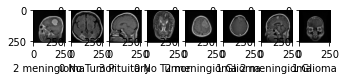

In [14]:
train_images = []
train_labels = []
test_images = []
test_labels = []
tr = 1000
ts = 200

temp = define_label('/content/Training/notumor/',0,tr)
train_images = train_images + temp[0]
train_labels = train_labels + temp[1]

temp = define_label('/content/Training/glioma/',1,tr)
train_images = train_images + temp[0]
train_labels = train_labels + temp[1]

temp = define_label('/content/Training/meningioma/',2,tr)
train_images = train_images + temp[0]
train_labels = train_labels + temp[1]

temp = define_label('/content/Training/pituitary/',3,tr)
train_images = train_images + temp[0]
train_labels = train_labels + temp[1]

temp = define_label('/content/Training/notumor/',0,ts)
test_images = test_images + temp[0]
test_labels = test_labels + temp[1]

temp = define_label('/content/Training/glioma/',1,ts)
test_images = test_images + temp[0]
test_labels = test_labels + temp[1]

temp = define_label('/content/Training/meningioma/',2,ts)
test_images = test_images + temp[0]
test_labels = test_labels + temp[1]

temp = define_label('/content/Training/pituitary/',3,ts)
test_images = test_images + temp[0]
test_labels = test_labels + temp[1]


print(len(train_images))
print(len(train_labels))

print(len(test_images))
print(len(test_labels))


labels = ['No Tumor','Glioma','meningioma','Pituitary']
for i in range (1,9):
    plt.subplot(1,9,i)
    random = np.random.randint(0,len(train_images))
    plt.imshow(train_images[random])
    
    plt.xlabel(str(train_labels[random])+' '+str(labels[train_labels[random]]))
    #print(train_labels[random],labels[train_labels[random]])

In [15]:
train_labels = np.array(train_labels)
train_labels = train_labels.reshape(train_labels.shape[0],1)
print(len(train_labels))
print(len(train_images))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(test_labels.shape[0],1)
print(len(test_labels))

4000
4000
800


In [16]:
print(len(train_images))
train_images = np.array(train_images)
train_images = train_images.astype('float32') / 255.0
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0



print('x_train shape',train_images.shape)
print(train_images.shape[0],'train samples')
print(test_images.shape[0],'test samples')
print('y_train shape',train_labels.shape)
print('x_test shape',test_images.shape)

4000
x_train shape (4000, 256, 256, 3)
4000 train samples
800 test samples
y_train shape (4000, 1)
x_test shape (800, 256, 256, 3)


In [17]:
#create a deep learning model using Keras
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)), #254x254x32
    keras.layers.MaxPooling2D((2, 2)), #127x127x32
    keras.layers.Conv2D(64, (3, 3), activation='relu'), #125x125x64
    keras.layers.MaxPooling2D((2, 2)), # 62x62x64
    keras.layers.Conv2D(128, (3, 3), activation='relu'), #60x60x128
    keras.layers.MaxPooling2D((2, 2)), #30x30x128
    keras.layers.Flatten(), #115200 
    keras.layers.Dense(512, activation='relu'), #512
    keras.layers.Dense(4, activation='softmax') #4
])

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
"""from keras.models import Sequential
from keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, AveragePooling2D

# build the model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())

# Block 2
model.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 3
model.add(DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 4
model.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 5
model.add(DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 6
model.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 7
model.add(DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 8-11
for i in range(4):
    model.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (1, 1), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())

# Block 12
model.add(DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(1024, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 13
model.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(1024, (1, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Block 14
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""


"from keras.models import Sequential\nfrom keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, AveragePooling2D\n\n# build the model\nmodel = Sequential()\n\n# Block 1\nmodel.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(256, 256, 3)))\nmodel.add(BatchNormalization())\n\n# Block 2\nmodel.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(Activation('relu'))\nmodel.add(Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu'))\nmodel.add(BatchNormalization())\n\n# Block 3\nmodel.add(DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(Activation('relu'))\nmodel.add(Conv2D(128, (1, 1), strides=(1, 1), padding='same', activation='relu'))\nmodel.add(BatchNormalization())\n\n# Block 4\nmodel.add(DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))\nmodel.add(BatchNormalization())\nmode

In [19]:
"""from tensorflow.keras.applications import EfficientNetB0,DenseNet121,VGG16,EfficientNetB7

transferModel = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(256,256,3))

model = transferModel.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs= transferModel.input, outputs = model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

"from tensorflow.keras.applications import EfficientNetB0,DenseNet121,VGG16,EfficientNetB7\n\ntransferModel = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(256,256,3))\n\nmodel = transferModel.output\nmodel = tf.keras.layers.GlobalAveragePooling2D()(model)\nmodel = tf.keras.layers.Dropout(rate=0.5)(model)\nmodel = tf.keras.layers.Dense(4,activation='softmax')(model)\nmodel = tf.keras.models.Model(inputs= transferModel.input, outputs = model)\n\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"

In [20]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("transferModel.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [21]:
# one-hot encode the class labels
train_labels = keras.utils.to_categorical(train_labels, num_classes=4)
test_labels = keras.utils.to_categorical(test_labels, num_classes=4)

# train the model

epoch = 2
history = model.fit(train_images, train_labels, epochs=epoch, batch_size=16, validation_data=(test_images, test_labels))
model.save('my_model.h5')
# evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(test_images, test_labels)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

Epoch 1/2
250/250 [==============================] - 836s 3s/step - loss: 0.7710 - accuracy: 0.7297 - val_loss: 0.2979 - val_accuracy: 0.8988
Epoch 2/2
25/25 [==============================] - 33s 1s/step - loss: 0.2593 - accuracy: 0.9000
Validation Loss: 0.25931867957115173
Validation Accuracy: 0.8999999761581421


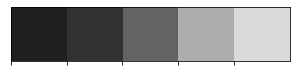

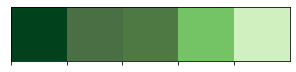

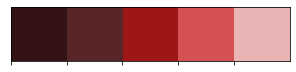

In [22]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

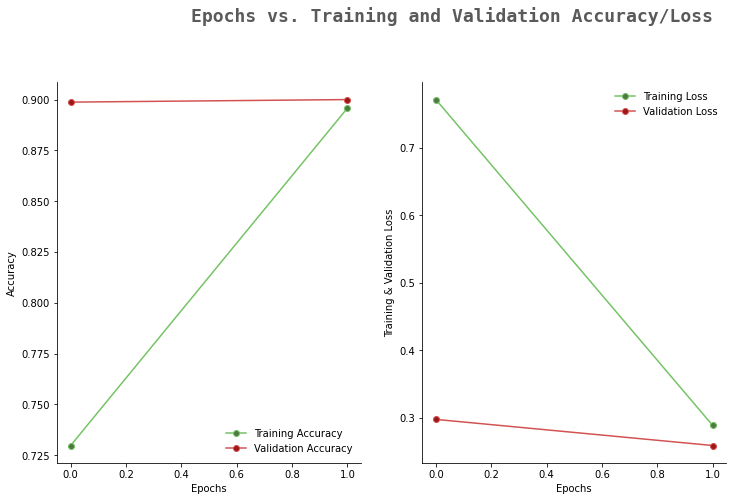

In [24]:
filterwarnings('ignore')

epochs = [i for i in range(epoch)]
fig, ax = plt.subplots(1,2,figsize=(12,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

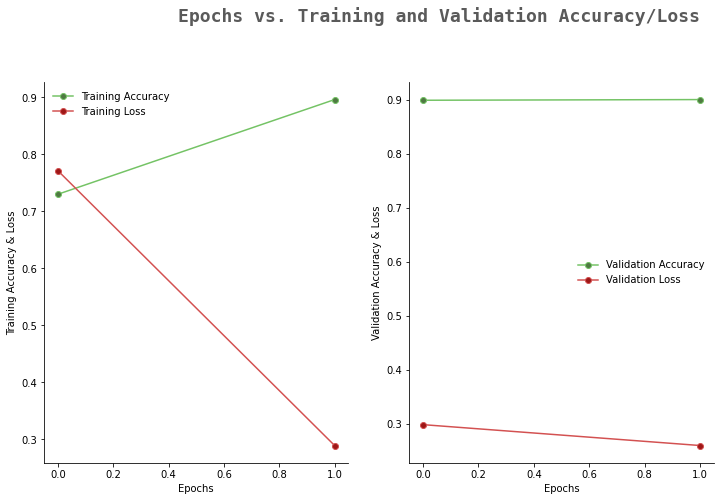

In [25]:
filterwarnings('ignore')

epochs = [i for i in range(epoch)]
fig, ax = plt.subplots(1,2,figsize=(12,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, train_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Training Loss')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Accuracy & Loss')

sns.despine()
ax[1].plot(epochs, val_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Validation Accuracy')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Validation Accuracy & Loss')

fig.show()


In [26]:
pred = model.predict(test_images)

pred = np.argmax(pred,axis=1)

y_test_new = np.argmax(test_labels,axis=1)

25/25 [==============================] - 35s 1s/step


In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       200
           1       0.84      0.98      0.91       200
           2       0.98      0.65      0.78       200
           3       0.96      0.97      0.97       200

    accuracy                           0.90       800
   macro avg       0.91      0.90      0.89       800
weighted avg       0.91      0.90      0.89       800



In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

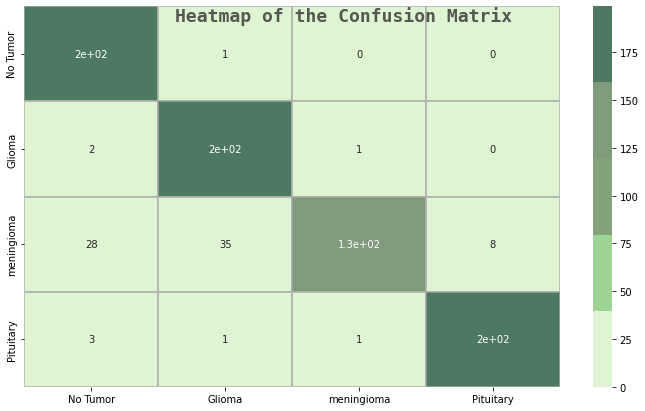

In [30]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.85,x=0.30,alpha=0.8)

plt.show()

In [31]:

loaded_model = load_model('my_model.h5')